<a href="https://colab.research.google.com/github/SanghunOh/study_machinglearning/blob/main/codes/sanghunoh/reports/%EA%B3%BC%EC%A0%9C_5_1_%EA%B0%80%EC%9A%B0%EC%8B%9C%EC%95%88%ED%98%BC%ED%95%A9%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. (50점) 가우시안 혼합 모델을 사용하여 주어진 데이터 HW5Data_1.mat에 대한 분석을 수행하시오.

##(1) (10점) 데이터 HW5Data_1.mat을 불러온 다음 2차원 평면에 산점도를 그리시오.  (단, scatter 함수 사용할 것)

In [1]:
!pip install mat73

In [2]:
# read features and labels from dataset file(mat)
# from https://github.com/SanghunOh/study_machinglearning/blob/main/datas/HW5Data_1.mat

import mat73
mat_contents = mat73.loadmat('./HW5Data_1.mat')
type(mat_contents), mat_contents.keys(),

(dict, dict_keys(['data']))

In [3]:
datas = mat_contents['data']
datas.shape

(800, 2)

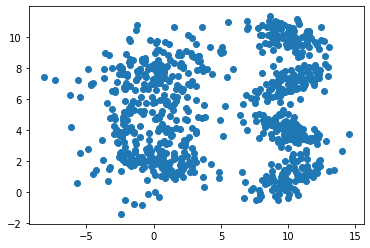

In [4]:
import matplotlib.pyplot as plt
plt.scatter(datas[:,0], datas[:,1])
plt.show()

##(2) (20점) 교재 프로그램 10-1을 활용하여, 주어진 데이터에 대한 가우시안 혼합 모델을 적용하여 분석을 수행하시오. 이때 가우시안 성분의 수는 {2, 6, 10} 으로 변경해 가며 수행하고, 각각의 최종 결과를 산점도로 출력하여 이를 비교한 후 그 결과를 서술하시오.

In [5]:
datas_transpose = datas.T # 계산 편리 위해 전치
datas_transpose.shape

(2, 800)

In [6]:
def gausspdf(X, mu, sigma):
  n = X.shape[0]    # 입력 벡터의 차원
  N = X.shape[1]    # 데이터의 수
  Mu = np.matlib.repmat(np.reshape(mu,(-1,1)),1,N)  # 행렬 연산을 위한 준비
  # 확률 밀도값 계산
  res = (1 / ((np.sqrt(2*np.pi))**n * np.sqrt(np.linalg.det(sigma)))) \
        * np.exp(-np.diag((X-Mu).T @ np.linalg.inv(sigma) @(X-Mu)) / 2)
  #print(np.exp(1))
  return res

In [7]:
import matplotlib.pyplot as plt
import math
from numpy import matlib
from scipy import linalg
def drawgraph(_X, _Mu, _Sigma, _cnt):
  _M=_Mu[:,1].size
  
  plt.figure(num=_cnt)     #데이터 그리기
  plt.title(f'loop count : {_cnt}')          #check point
  plt.plot(_X[0,:], _X[1,:], marker='*', linestyle='None')
  plt.plot(_Mu[:,0], _Mu[:,1], marker='o', linestyle='None')  #평균 파라미터 그리기
  #print("M=",_M)
  for j in range(_M):
    #공분산에 따른 타원 그리기
    sigma = np.asarray(np.reshape(_Sigma[j,:,:],(2,2)))
    #print("sigma=",sigma)
    t=np.arange(-math.pi,math.pi,0.1)
    A=math.sqrt(2)*np.asarray([np.cos(t), np.sin(t)]).T.dot(linalg.sqrtm(sigma))+ matlib.repmat(_Mu[j,:],t.size,1)
    plt.plot(A[:,0], A[:,1], marker='h', markersize=3, linestyle='None')
  plt.show()

In [8]:
def drawLoglikelihood(L):
  plt.plot(L)                                                 # 로그우도의 변환 그래프
  plt.xlabel("Number of iteration")
  plt.ylabel("Log-likelihood")
  plt.show()

In [9]:
def multi_gaussian_EM(M, N, X):
  # _mu_list, _sigma_list, _tau_list = list(), list(), list()
  __Mu = np.random.rand(M,2)*5                  # 파라메터 설정
  __Sigma = np.zeros([M,2,2])
  for i in range(M):                          #파라미터 초기화(평균)
    __Sigma[i,:,:] = [[1,0],[0,1]]
  alpha = (np.zeros([M,1])+1)/M               # 파라미터 초기화(혼합계수)

  drawgraph(X,__Mu, __Sigma,0);                   # 그래프 그리기 함수 호출

  Maxtau = 100          # 최대 반복횟수 설정
  px = np.zeros([M,N]) #(M*N)
  r = np.empty([N,M]) #(N*M)
  L = np.arange(0,100)

  for tau in range(Maxtau):
    # E-step : M 번째 반복단계에서 주어진 파라미터를 이용하여 기대치를 계산한다.
    for j in range(M):                  #p 계산
      px[j,:] = gausspdf(X, __Mu[j,:], np.reshape(__Sigma[j,:,:],(2,2)))
    sump=px.T @ alpha                   #알파, p 계산
    for j in range(M):                  # r 계산
      r[:,j] = np.reshape((np.reshape((alpha[j] * px[j,:]),(-1,1)) / sump),(-1));
    L[tau] = sum(np.log(sump))                  # 현재 파라미터의 로그우도 계산
    #print(L[tau])
    #M-Step : E-step 에서 얻어진 기대치를 이용하여 파라미터를 계산한다.
    for j in range(M):
      sumr=sum(r[:,j])                                        #r의 성분별 합산
      Rj = np.matlib.repmat(r[:,j],2,1)                       #행렬계산을 위한 준비
      __Mu[j,:] = np.sum(Rj * X, axis=1) / sumr                 # 새로운 평균
      # 새로운 공분산 계산
      rxmu = (X - np.matlib.repmat(__Mu[j,:],N,1).T) * Rj
      __Sigma[j,:,:] = rxmu @ \
                    (X - np.matlib.repmat(__Mu[j,:],N,1).T).T / sumr
      alpha[j] = sumr/N                                       # 새로운 혼합계수
    if tau == 0 or (tau%10) == 4:                                # 그래프 그리기 함수 호출
      _tau = int(np.ceil(tau)+1)
      drawgraph(X, __Mu, __Sigma, _tau)

  drawLoglikelihood(L)

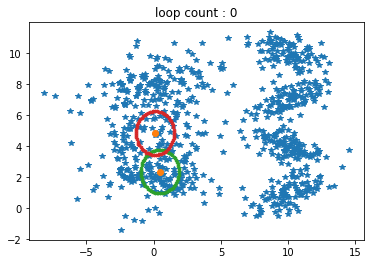

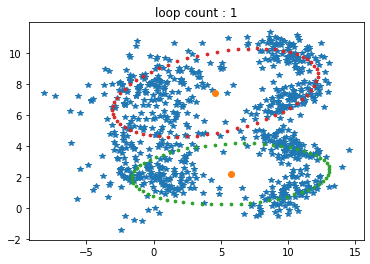

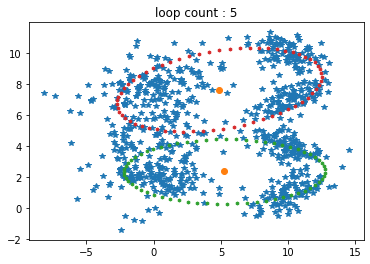

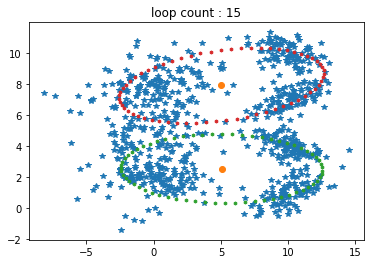

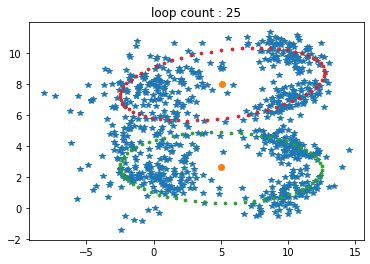

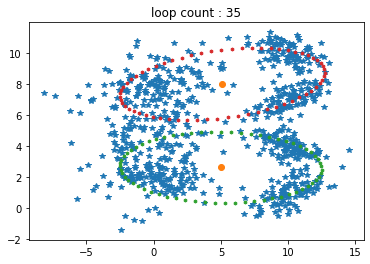

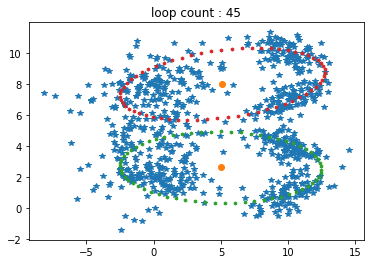

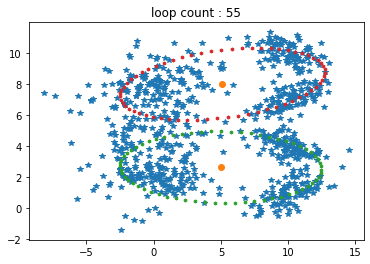

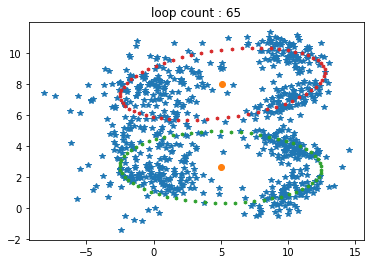

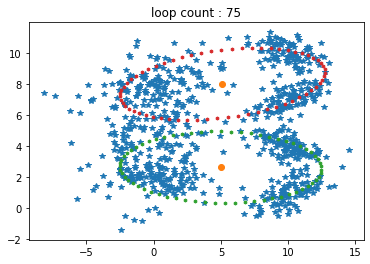

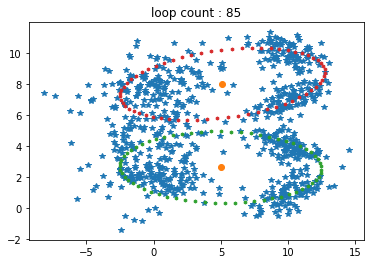

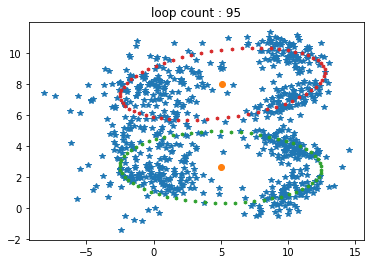

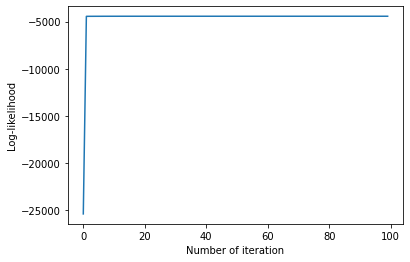

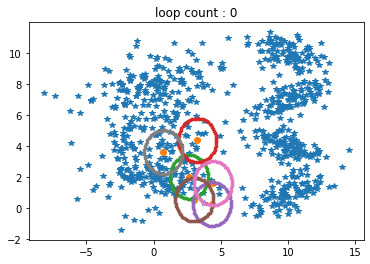

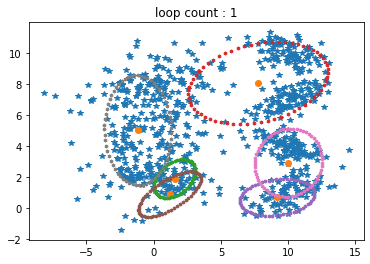

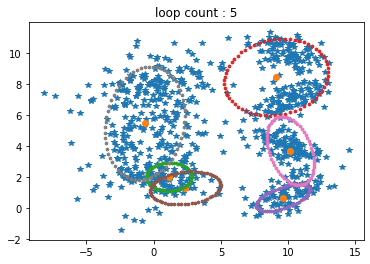

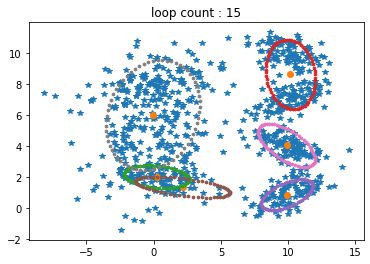

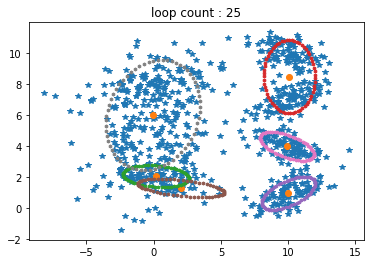

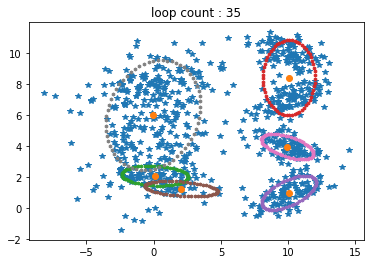

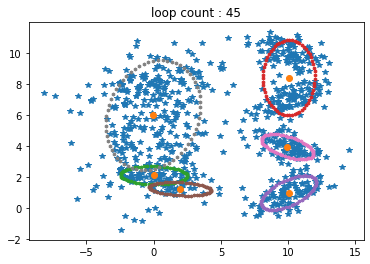

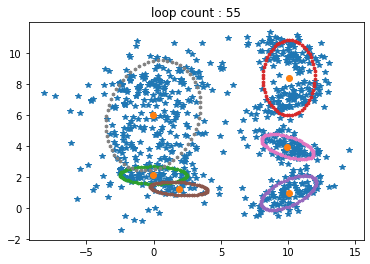

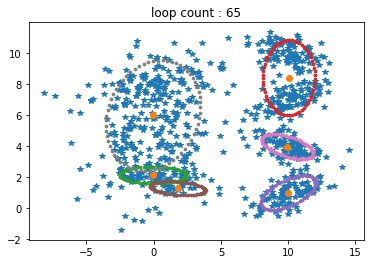

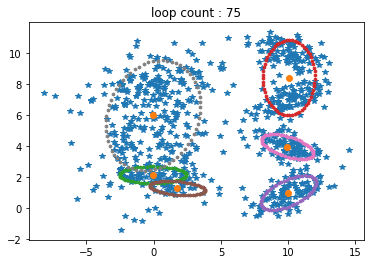

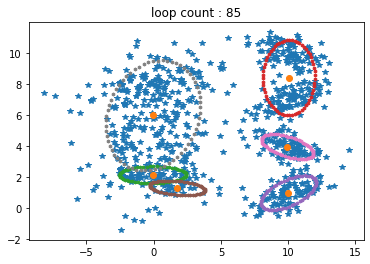

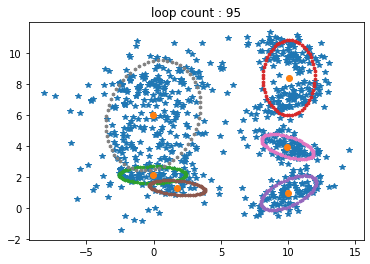

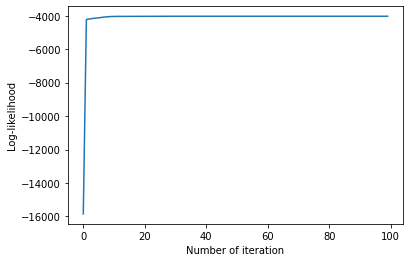

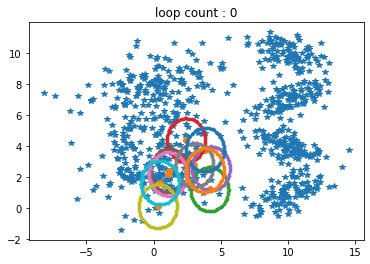

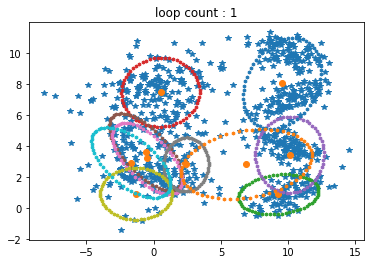

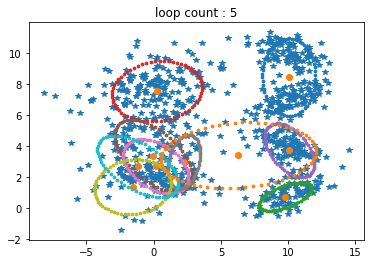

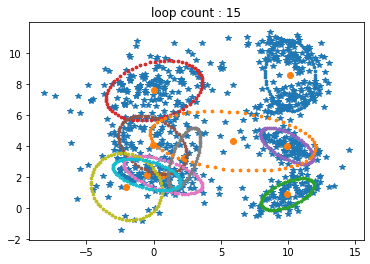

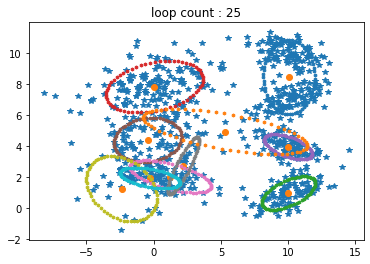

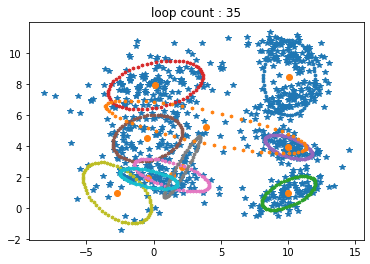

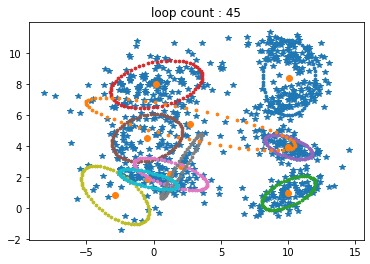

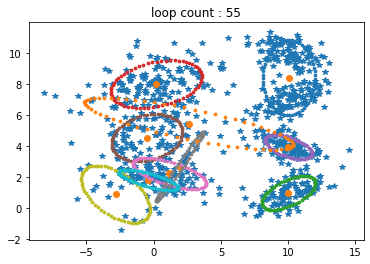

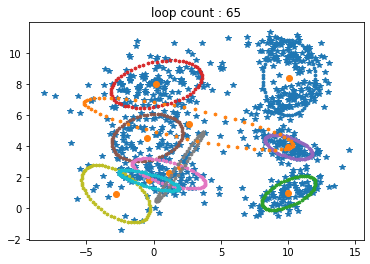

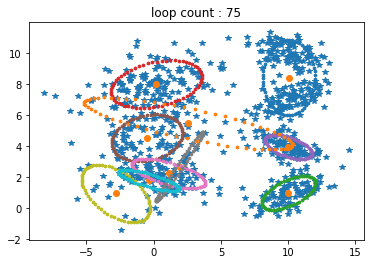

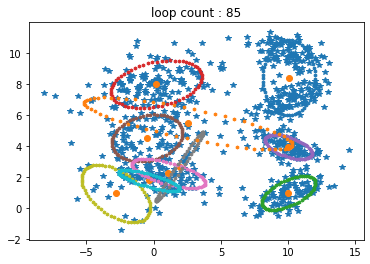

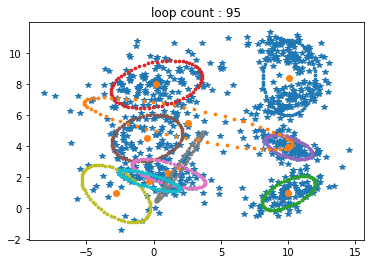

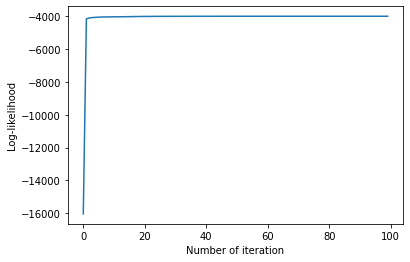

In [10]:
import numpy as np
rows = datas_transpose.shape[1]                              # 데이터의 수
n_clusters = [2,6,10]                                       # 가우시안 성분의 수
for n_cluster in n_clusters:
  multi_gaussian_EM(n_cluster, rows, datas_transpose)
